# Multi-Layer Ray Tracing for Urban RF Planning

This notebook demonstrates how to use rtxpy's **multi-GAS (Geometry Acceleration Structure)** feature to trace rays through a scene with multiple geometry layers and identify which obstacle blocks each signal path.

**Scenario:** Planning cell tower placement for a mountain town with:
- Rugged terrain (hills and valleys blocking line-of-sight)
- Buildings of various heights
- Tree coverage that attenuates signals

## What You'll Learn

1. Downloading terrain data from USGS
2. Creating multiple geometry layers with `add_geometry()`
3. Building 3D structures (buildings and trees) programmatically
4. Identifying hit layers using the `instance_ids` parameter
5. Visualizing obstruction analysis results

## Technical Background

rtxpy uses NVIDIA OptiX for hardware-accelerated ray tracing. The multi-GAS feature allows:

- Adding multiple independent geometry "layers" to a scene
- Each layer gets its own **Instance ID** (0, 1, 2, ...)
- Querying which instance a ray hit
- Analysis like: "Was this signal blocked by terrain, a building, or a tree?"

## 1. Setup and Dependencies

In [1]:
# Core imports
import numpy as np
import cupy as cp
import xarray as xr
import rioxarray as rxr
import requests
from pathlib import Path
import time

# Visualization
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# rtxpy
from rtxpy import RTX, triangulate_terrain, hillshade

print(f"CuPy: {cp.__version__}, CUDA: {cp.cuda.runtime.runtimeGetVersion()}")

CuPy: 13.6.0, CUDA: 13000


## 2. Load Terrain Data

We'll download real SRTM elevation data from USGS for a section of the Colorado foothills.

In [2]:
def download_terrain(bounds, output_path):
    """Download SRTM 1-arc-second elevation data from USGS.
    
    Parameters
    ----------
    bounds : tuple
        (west, south, east, north) in WGS84 degrees
    output_path : Path
        Where to save the clipped DEM
    """
    import math
    from rioxarray.merge import merge_arrays
    
    west, south, east, north = bounds
    
    # First, check if we have a local DEM that covers this area
    local_dem = output_path.parent / "denver_dem_wgs84.tif"
    if local_dem.exists():
        print(f"Checking local DEM: {local_dem}")
        local_data = rxr.open_rasterio(str(local_dem), masked=True).squeeze()
        local_bounds = local_data.rio.bounds()
        # Check if local DEM covers requested bounds
        if (local_bounds[0] <= west and local_bounds[1] <= south and 
            local_bounds[2] >= east and local_bounds[3] >= north):
            print("  Local DEM covers requested area, using it...")
            clipped = local_data.rio.clip_box(minx=west, miny=south, maxx=east, maxy=north)
            clipped.rio.to_raster(str(output_path))
            print(f"  Saved to {output_path}")
            return clipped
    
    # Determine 1x1 degree tiles needed
    lat_min, lat_max = math.floor(south), math.floor(north)
    lon_min, lon_max = math.floor(west), math.floor(east)
    
    base_url = "https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/current"
    tile_paths = []
    
    print("Downloading SRTM elevation data...")
    
    for lat in range(lat_min, lat_max + 1):
        for lon in range(lon_min, lon_max + 1):
            ns = "n" if lat >= 0 else "s"
            ew = "w" if lon < 0 else "e"
            tile_name = f"{ns}{abs(lat):02d}{ew}{abs(lon):03d}"
            url = f"{base_url}/{tile_name}/USGS_1_{tile_name}.tif"
            tile_path = output_path.parent / f"USGS_1_{tile_name}.tif"
            
            if not tile_path.exists():
                print(f"  Downloading {tile_name}...")
                resp = requests.get(url, timeout=120)
                resp.raise_for_status()
                tile_path.write_bytes(resp.content)
            else:
                print(f"  Using cached {tile_name}")
            tile_paths.append(tile_path)
    
    # Merge and clip tiles
    tiles = [rxr.open_rasterio(str(p), masked=True).squeeze() for p in tile_paths]
    merged = merge_arrays(tiles) if len(tiles) > 1 else tiles[0]
    clipped = merged.rio.clip_box(minx=west, miny=south, maxx=east, maxy=north)
    clipped.rio.to_raster(str(output_path))
    
    print(f"  Saved to {output_path}")
    return clipped


# Study area: A portion of the Colorado foothills
# Small area for faster processing in this demo
BOUNDS = (-105.35, 39.70, -105.25, 39.78)  # ~10km x 9km area
DEM_PATH = Path.cwd() / "multi_gas_demo_terrain.tif"

if not DEM_PATH.exists():
    terrain = download_terrain(BOUNDS, DEM_PATH)
else:
    print(f"Using existing DEM: {DEM_PATH}")
    terrain = rxr.open_rasterio(str(DEM_PATH), masked=True).squeeze()

# Subsample for performance (every 2nd pixel)
terrain = terrain[::2, ::2]

# Get terrain info
H, W = terrain.shape
elev_min, elev_max = float(terrain.min()), float(terrain.max())

print(f"\nTerrain loaded:")
print(f"  Shape: {H} x {W} pixels")
print(f"  Elevation: {elev_min:.0f}m to {elev_max:.0f}m")
print(f"  Relief: {elev_max - elev_min:.0f}m")

Using existing DEM: /home/brendan/rtxpy/examples/multi_gas_demo_terrain.tif

Terrain loaded:
  Shape: 145 x 181 pixels
  Elevation: 1754m to 2516m
  Relief: 762m


/home/brendan/miniconda/envs/xarray-spatial-everything/lib/python3.14/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 26 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/brendan/miniconda/envs/xarray-spatial-everything/lib/python3.14/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 30 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/brendan/miniconda/envs/xarray-spatial-everything/lib/python3.14/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 30 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/brendan/miniconda/envs/xarray-spatial-everything/lib/python3.14/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 30 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerfo

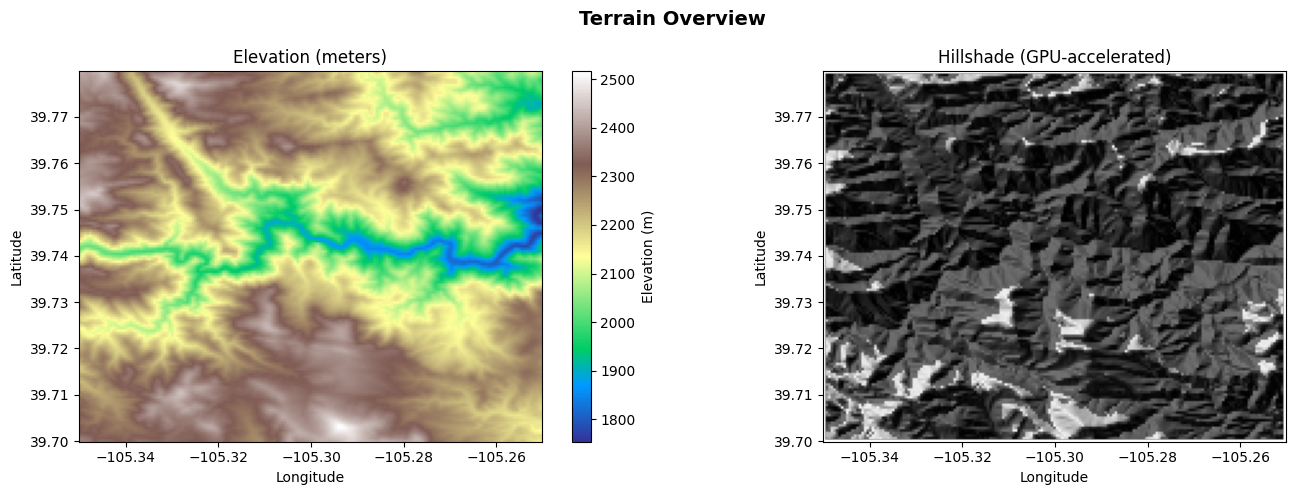

In [3]:
# Visualize the terrain with hillshade
terrain_gpu = terrain.copy()
terrain_gpu.data = cp.asarray(np.ascontiguousarray(terrain.data))

rtx = RTX()
hs = hillshade(terrain_gpu, shadows=True, azimuth=315, angle_altitude=35, rtx=rtx)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Raw elevation
im1 = axes[0].imshow(terrain.data, cmap='terrain', 
                      extent=[float(terrain.x.min()), float(terrain.x.max()),
                              float(terrain.y.min()), float(terrain.y.max())])
axes[0].set_title('Elevation (meters)', fontsize=12)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
plt.colorbar(im1, ax=axes[0], label='Elevation (m)')

# Right: Hillshade
hs_data = hs.data.get() if hasattr(hs.data, 'get') else hs.data
axes[1].imshow(hs_data, cmap='gray',
               extent=[float(terrain.x.min()), float(terrain.x.max()),
                       float(terrain.y.min()), float(terrain.y.max())])
axes[1].set_title('Hillshade (GPU-accelerated)', fontsize=12)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

plt.suptitle("Terrain Overview", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Create Building Geometry

We'll create mock buildings as 3D boxes (cuboids). Each building is defined by 8 vertices and 12 triangles (2 per face).

In [4]:
def create_box_mesh(width, depth, height):
    """
    Create a box (cuboid) mesh centered at origin.
    
    Returns vertices (24 floats: 8 vertices * 3 coords) and
    triangles (36 ints: 12 triangles * 3 indices).
    """
    w, d, h = width / 2, depth / 2, height
    
    # 8 vertices of the box (bottom 4, then top 4)
    vertices = np.array([
        # Bottom face (z=0)
        -w, -d, 0,   # 0: back-left
         w, -d, 0,   # 1: back-right
         w,  d, 0,   # 2: front-right
        -w,  d, 0,   # 3: front-left
        # Top face (z=height)
        -w, -d, h,   # 4: back-left
         w, -d, h,   # 5: back-right
         w,  d, h,   # 6: front-right
        -w,  d, h,   # 7: front-left
    ], dtype=np.float32)
    
    # 12 triangles (2 per face, 6 faces)
    triangles = np.array([
        # Bottom face
        0, 2, 1,  0, 3, 2,
        # Top face
        4, 5, 6,  4, 6, 7,
        # Front face
        3, 6, 2,  3, 7, 6,
        # Back face
        0, 1, 5,  0, 5, 4,
        # Left face
        0, 4, 7,  0, 7, 3,
        # Right face
        1, 2, 6,  1, 6, 5,
    ], dtype=np.int32)
    
    return vertices, triangles


def place_buildings_on_terrain(terrain, num_buildings=25, seed=42):
    """
    Generate random building placements on the terrain.
    
    Returns a list of dicts with building properties.
    """
    np.random.seed(seed)
    
    H, W = terrain.shape
    x_coords = terrain.x.values
    y_coords = terrain.y.values
    elev_data = terrain.data
    if hasattr(elev_data, 'get'):
        elev_data = elev_data.get()
    
    buildings = []
    
    for i in range(num_buildings):
        # Random position (avoid edges)
        row = np.random.randint(10, H - 10)
        col = np.random.randint(10, W - 10)
        
        # Get terrain coordinates and elevation
        x = float(x_coords[col])
        y = float(y_coords[row])
        z = float(elev_data[row, col])
        
        # Skip if elevation is NaN
        if np.isnan(z):
            continue
        
        # Random building size
        # Small houses vs larger commercial buildings
        if np.random.random() < 0.7:
            # Residential: smaller, lower
            width = np.random.uniform(8, 15)   # meters
            depth = np.random.uniform(8, 12)
            height = np.random.uniform(4, 8)   # 1-2 stories
            btype = 'residential'
        else:
            # Commercial: larger, taller
            width = np.random.uniform(20, 40)
            depth = np.random.uniform(15, 30)
            height = np.random.uniform(10, 25)  # 3-6 stories
            btype = 'commercial'
        
        buildings.append({
            'id': f'building_{i}',
            'type': btype,
            'x': x, 'y': y, 'z': z,
            'width': width, 'depth': depth, 'height': height,
            'row': row, 'col': col
        })
    
    return buildings


# Generate buildings
buildings = place_buildings_on_terrain(terrain, num_buildings=30)

residential = [b for b in buildings if b['type'] == 'residential']
commercial = [b for b in buildings if b['type'] == 'commercial']

print(f"Generated {len(buildings)} buildings:")
print(f"  Residential: {len(residential)}")
print(f"  Commercial: {len(commercial)}")
print(f"\nSample building: {buildings[0]}")

Generated 30 buildings:
  Residential: 25
  Commercial: 5

Sample building: {'id': 'building_0', 'type': 'residential', 'x': -105.2934722219797, 'y': 39.717638888942226, 'z': 2380.730224609375, 'width': 13.457837001909386, 'depth': 10.387400631785948, 'height': 5.783331011414365, 'row': 112, 'col': 102}


In [5]:
def merge_building_meshes(buildings):
    """
    Merge all buildings into a single mesh for the buildings layer.
    
    Each building is transformed to its world position before merging.
    """
    all_verts = []
    all_tris = []
    vertex_offset = 0
    
    for b in buildings:
        # Create box mesh
        verts, tris = create_box_mesh(b['width'], b['depth'], b['height'])
        
        # Transform vertices to world position
        # Note: Terrain uses lat/lon in degrees, but we'll work in pixel coordinates
        # for simplicity and transform to match terrain mesh coordinates
        verts_reshaped = verts.reshape(-1, 3)
        verts_reshaped[:, 0] += b['col']  # x -> column
        verts_reshaped[:, 1] += b['row']  # y -> row
        verts_reshaped[:, 2] += b['z']    # z -> elevation + height
        
        # Add offset to triangle indices
        tris_offset = tris + vertex_offset
        
        all_verts.append(verts_reshaped.flatten())
        all_tris.append(tris_offset)
        
        vertex_offset += 8  # 8 vertices per box
    
    merged_verts = np.concatenate(all_verts).astype(np.float32)
    merged_tris = np.concatenate(all_tris).astype(np.int32)
    
    return merged_verts, merged_tris


# Create merged building mesh
building_verts, building_tris = merge_building_meshes(buildings)

print(f"Building mesh:")
print(f"  Vertices: {len(building_verts) // 3}")
print(f"  Triangles: {len(building_tris) // 3}")

Building mesh:
  Vertices: 240
  Triangles: 360


## 4. Create Tree Geometry

We'll model trees as simplified cone shapes (pyramids) - a common approximation for conifers. Trees are placed preferentially at higher elevations.

In [6]:
def create_tree_mesh(trunk_height, canopy_height, canopy_radius):
    """
    Create a simplified conifer tree mesh.
    
    The tree consists of a vertical trunk (thin box) and a conical canopy.
    For simplicity, we use a pyramid for the canopy.
    """
    # Trunk (thin vertical box)
    trunk_width = canopy_radius * 0.15
    trunk_verts = np.array([
        -trunk_width, -trunk_width, 0,
         trunk_width, -trunk_width, 0,
         trunk_width,  trunk_width, 0,
        -trunk_width,  trunk_width, 0,
        -trunk_width, -trunk_width, trunk_height,
         trunk_width, -trunk_width, trunk_height,
         trunk_width,  trunk_width, trunk_height,
        -trunk_width,  trunk_width, trunk_height,
    ], dtype=np.float32)
    
    trunk_tris = np.array([
        0, 2, 1,  0, 3, 2,  # bottom
        4, 5, 6,  4, 6, 7,  # top
        0, 1, 5,  0, 5, 4,  # back
        2, 3, 7,  2, 7, 6,  # front
        0, 4, 7,  0, 7, 3,  # left
        1, 2, 6,  1, 6, 5,  # right
    ], dtype=np.int32)
    
    # Canopy (pyramid/cone approximation with 8 sides)
    n_sides = 8
    canopy_verts = []
    canopy_tris = []
    
    # Base vertices of canopy (at trunk_height * 0.6)
    base_z = trunk_height * 0.6
    for i in range(n_sides):
        angle = 2 * np.pi * i / n_sides
        x = canopy_radius * np.cos(angle)
        y = canopy_radius * np.sin(angle)
        canopy_verts.extend([x, y, base_z])
    
    # Apex vertex
    apex_z = trunk_height + canopy_height
    apex_idx = n_sides
    canopy_verts.extend([0, 0, apex_z])
    
    # Center of base
    center_idx = n_sides + 1
    canopy_verts.extend([0, 0, base_z])
    
    canopy_verts = np.array(canopy_verts, dtype=np.float32)
    
    # Triangles: sides of cone + base
    for i in range(n_sides):
        next_i = (i + 1) % n_sides
        # Side triangle
        canopy_tris.extend([i, next_i, apex_idx])
        # Base triangle
        canopy_tris.extend([i, center_idx, next_i])
    
    canopy_tris = np.array(canopy_tris, dtype=np.int32)
    
    # Offset canopy triangle indices by trunk vertex count
    canopy_tris_offset = canopy_tris + 8
    
    # Combine trunk and canopy
    all_verts = np.concatenate([trunk_verts, canopy_verts])
    all_tris = np.concatenate([trunk_tris, canopy_tris_offset])
    
    return all_verts, all_tris


def place_trees_on_terrain(terrain, num_trees=100, seed=123):
    """
    Place trees on higher elevation areas (forested hillsides).
    """
    np.random.seed(seed)
    
    H, W = terrain.shape
    x_coords = terrain.x.values
    y_coords = terrain.y.values
    elev_data = terrain.data
    if hasattr(elev_data, 'get'):
        elev_data = elev_data.get()
    
    # Trees prefer higher elevations (above median)
    median_elev = np.nanmedian(elev_data)
    
    trees = []
    attempts = 0
    max_attempts = num_trees * 10
    
    while len(trees) < num_trees and attempts < max_attempts:
        attempts += 1
        
        row = np.random.randint(5, H - 5)
        col = np.random.randint(5, W - 5)
        z = float(elev_data[row, col])
        
        if np.isnan(z):
            continue
            
        # Higher probability of trees at higher elevations
        if z < median_elev and np.random.random() < 0.7:
            continue
        
        # Random tree size
        trunk_height = np.random.uniform(8, 15)
        canopy_height = np.random.uniform(6, 12)
        canopy_radius = np.random.uniform(2, 4)
        
        trees.append({
            'id': f'tree_{len(trees)}',
            'row': row, 'col': col, 'z': z,
            'trunk_height': trunk_height,
            'canopy_height': canopy_height,
            'canopy_radius': canopy_radius
        })
    
    return trees


# Generate trees
trees = place_trees_on_terrain(terrain, num_trees=80)
print(f"Generated {len(trees)} trees")

Generated 80 trees


In [7]:
def merge_tree_meshes(trees):
    """Merge all tree meshes into a single geometry."""
    all_verts = []
    all_tris = []
    vertex_offset = 0
    
    for t in trees:
        verts, tris = create_tree_mesh(
            t['trunk_height'], t['canopy_height'], t['canopy_radius']
        )
        
        # Transform to world position
        verts_reshaped = verts.reshape(-1, 3)
        verts_reshaped[:, 0] += t['col']
        verts_reshaped[:, 1] += t['row']
        verts_reshaped[:, 2] += t['z']
        
        # Offset indices
        tris_offset = tris + vertex_offset
        
        all_verts.append(verts_reshaped.flatten())
        all_tris.append(tris_offset)
        
        num_verts = len(verts) // 3
        vertex_offset += num_verts
    
    merged_verts = np.concatenate(all_verts).astype(np.float32)
    merged_tris = np.concatenate(all_tris).astype(np.int32)
    
    return merged_verts, merged_tris


# Create merged tree mesh
tree_verts, tree_tris = merge_tree_meshes(trees)

print(f"Tree mesh:")
print(f"  Vertices: {len(tree_verts) // 3}")
print(f"  Triangles: {len(tree_tris) // 3}")

Tree mesh:
  Vertices: 1440
  Triangles: 2240


## 5. Build the Multi-Layer Scene

Now we use `add_geometry()` to create distinct layers, each with its own Instance ID.

In [8]:
# First, triangulate the terrain
H, W = terrain.shape
num_terrain_verts = H * W
num_terrain_tris = (H - 1) * (W - 1) * 2

terrain_verts = np.zeros(num_terrain_verts * 3, dtype=np.float32)
terrain_tris = np.zeros(num_terrain_tris * 3, dtype=np.int32)

# Use rtxpy's triangulate_terrain
terrain_data = terrain.data
if hasattr(terrain_data, 'get'):
    terrain_data = terrain_data.get()
terrain_data = np.ascontiguousarray(terrain_data.astype(np.float64))

triangulate_terrain(terrain_verts, terrain_tris, terrain_data, scale=1.0)

print(f"Terrain mesh:")
print(f"  Vertices: {num_terrain_verts}")
print(f"  Triangles: {num_terrain_tris}")

Terrain mesh:
  Vertices: 26245
  Triangles: 51840


In [9]:
# Create a fresh RTX instance for the multi-GAS scene
rtx = RTX()
rtx.clear_scene()  # Ensure we start fresh

# Define our layer IDs for reference
LAYER_TERRAIN = 0
LAYER_BUILDINGS = 1
LAYER_TREES = 2

LAYER_NAMES = {
    LAYER_TERRAIN: "Terrain",
    LAYER_BUILDINGS: "Buildings",
    LAYER_TREES: "Trees",
    -1: "Sky (No Hit)"
}

# Add terrain layer (Instance ID will be 0)
print("Adding geometry layers...")
t0 = time.time()

res = rtx.add_geometry("terrain", terrain_verts, terrain_tris)
print(f"  [0] Terrain: {res == 0 and 'OK' or 'FAILED'}")

# Add buildings layer (Instance ID will be 1)
res = rtx.add_geometry("buildings", building_verts, building_tris)
print(f"  [1] Buildings: {res == 0 and 'OK' or 'FAILED'}")

# Add trees layer (Instance ID will be 2)
res = rtx.add_geometry("trees", tree_verts, tree_tris)
print(f"  [2] Trees: {res == 0 and 'OK' or 'FAILED'}")

t1 = time.time()
print(f"\nScene built in {(t1-t0)*1000:.1f}ms")
print(f"Total geometries: {rtx.get_geometry_count()}")
print(f"Geometry list: {rtx.list_geometries()}")

Adding geometry layers...
  [0] Terrain: OK
  [1] Buildings: OK
  [2] Trees: OK

Scene built in 3.9ms
Total geometries: 3
Geometry list: ['terrain', 'buildings', 'trees']


## 6. Trace Signal Paths

We'll set up a virtual cell tower on a hilltop and trace rays to every point on the terrain. The `instance_ids` parameter identifies which geometry layer blocks each ray.

In [10]:
# Place a "cell tower" on a high point
elev_data = terrain.data
if hasattr(elev_data, 'get'):
    elev_data = elev_data.get()

# Find a good hilltop location (high elevation, not on edge)
margin = 20
center_region = elev_data[margin:-margin, margin:-margin]
local_max_idx = np.unravel_index(np.nanargmax(center_region), center_region.shape)
tower_row = local_max_idx[0] + margin
tower_col = local_max_idx[1] + margin
tower_elev = float(elev_data[tower_row, tower_col])

# Tower height above ground
TOWER_HEIGHT = 30  # meters

# Tower position (in mesh coordinates: col = x, row = y, elev + height = z)
tower_x = float(tower_col)
tower_y = float(tower_row)
tower_z = tower_elev + TOWER_HEIGHT

print(f"Cell Tower Location:")
print(f"  Grid position: ({tower_row}, {tower_col})")
print(f"  Ground elevation: {tower_elev:.0f}m")
print(f"  Tower height: {TOWER_HEIGHT}m")
print(f"  Antenna height: {tower_z:.0f}m above sea level")

Cell Tower Location:
  Grid position: (100, 74)
  Ground elevation: 2430m
  Tower height: 30m
  Antenna height: 2460m above sea level


In [11]:
def trace_coverage_from_tower(rtx, tower_pos, terrain_shape, target_height=1.5):
    """
    Trace rays from a tower to every point on the terrain.
    
    Returns arrays indicating hit distance, which layer was hit first,
    and whether each point has line-of-sight to the tower.
    """
    H, W = terrain_shape
    tx, ty, tz = tower_pos
    
    # Create rays from tower to each terrain cell (at target_height above ground)
    num_rays = H * W
    
    # We'll trace in batches for memory efficiency
    batch_size = 100000
    
    # Output arrays
    hit_distances = np.full((H, W), np.nan, dtype=np.float32)
    hit_layers = np.full((H, W), -1, dtype=np.int32)
    
    # Get terrain elevations for target points
    elev = terrain.data
    if hasattr(elev, 'get'):
        elev = elev.get()
    
    print(f"Tracing {num_rays:,} rays...")
    t_start = time.time()
    
    rays_traced = 0
    for batch_start in range(0, num_rays, batch_size):
        batch_end = min(batch_start + batch_size, num_rays)
        batch_count = batch_end - batch_start
        
        # Generate ray data for this batch
        rays = np.zeros(batch_count * 8, dtype=np.float32)
        
        for i, idx in enumerate(range(batch_start, batch_end)):
            row = idx // W
            col = idx % W
            
            # Target point (at receiver height above terrain)
            target_x = float(col)
            target_y = float(row)
            target_z = float(elev[row, col]) + target_height
            
            if np.isnan(target_z):
                # Mark as invalid ray
                rays[i*8:(i+1)*8] = [tx, ty, tz, 0, 0, 0, 1, 0]  # Zero-length ray
                continue
            
            # Direction from tower to target
            dx = target_x - tx
            dy = target_y - ty
            dz = target_z - tz
            
            # Normalize direction
            length = np.sqrt(dx*dx + dy*dy + dz*dz)
            if length < 0.001:
                rays[i*8:(i+1)*8] = [tx, ty, tz, 0, 0, 0, 1, 0]
                continue
                
            dx, dy, dz = dx/length, dy/length, dz/length
            
            # Ray: origin, tmin, direction, tmax
            rays[i*8 + 0] = tx
            rays[i*8 + 1] = ty
            rays[i*8 + 2] = tz
            rays[i*8 + 3] = 0.1  # Small offset to avoid self-intersection
            rays[i*8 + 4] = dx
            rays[i*8 + 5] = dy
            rays[i*8 + 6] = dz
            rays[i*8 + 7] = length + 1.0  # Max distance (slightly more than needed)
        
        # Allocate hit buffers
        hits = np.zeros(batch_count * 4, dtype=np.float32)
        prim_ids = np.zeros(batch_count, dtype=np.int32)
        inst_ids = np.zeros(batch_count, dtype=np.int32)
        
        # Trace!
        res = rtx.trace(rays, hits, batch_count, 
                        primitive_ids=prim_ids, instance_ids=inst_ids)
        
        if res != 0:
            print(f"  Warning: Trace returned {res}")
            continue
        
        # Store results
        for i, idx in enumerate(range(batch_start, batch_end)):
            row = idx // W
            col = idx % W
            hit_distances[row, col] = hits[i * 4]  # t value
            hit_layers[row, col] = inst_ids[i]
        
        rays_traced += batch_count
        if rays_traced % 200000 == 0:
            print(f"  {rays_traced:,} / {num_rays:,} rays traced...")
    
    t_end = time.time()
    print(f"\nTracing complete in {t_end - t_start:.2f}s")
    print(f"  Rays per second: {num_rays / (t_end - t_start):,.0f}")
    
    return hit_distances, hit_layers


# Trace coverage
hit_distances, hit_layers = trace_coverage_from_tower(
    rtx, 
    (tower_x, tower_y, tower_z), 
    terrain.shape,
    target_height=1.5  # Receiver at 1.5m (person holding phone)
)

Tracing 26,245 rays...

Tracing complete in 0.06s
  Rays per second: 423,544


In [12]:
# Analyze which layer blocked each ray
terrain_hits = (hit_layers == LAYER_TERRAIN).sum()
building_hits = (hit_layers == LAYER_BUILDINGS).sum()
tree_hits = (hit_layers == LAYER_TREES).sum()
misses = (hit_layers == -1).sum()  # Ray missed all geometry (sky)

total = terrain_hits + building_hits + tree_hits + misses

print("=" * 50)
print("COVERAGE ANALYSIS RESULTS")
print("=" * 50)
print(f"\nRays blocked by:")
print(f"  Terrain:   {terrain_hits:>8,} ({100*terrain_hits/total:>5.1f}%)")
print(f"  Buildings: {building_hits:>8,} ({100*building_hits/total:>5.1f}%)")
print(f"  Trees:     {tree_hits:>8,} ({100*tree_hits/total:>5.1f}%)")
print(f"  Clear LOS: {misses:>8,} ({100*misses/total:>5.1f}%)")
print(f"  " + "-" * 30)
print(f"  Total:     {total:>8,}")

# Note: "Clear LOS" here means the ray reached the target without hitting
# any obstruction first (hit the terrain AT the target point, which is good!)

COVERAGE ANALYSIS RESULTS

Rays blocked by:
  Terrain:     17,332 ( 66.0%)
  Buildings:    4,151 ( 15.8%)
  Trees:        2,049 (  7.8%)
  Clear LOS:    2,713 ( 10.3%)
  ------------------------------
  Total:       26,245


## 7. Visualize Results

Color-coded coverage map showing which layer blocks each signal path. Colors are chosen to be colorblind-friendly (blue/orange/yellow palette).

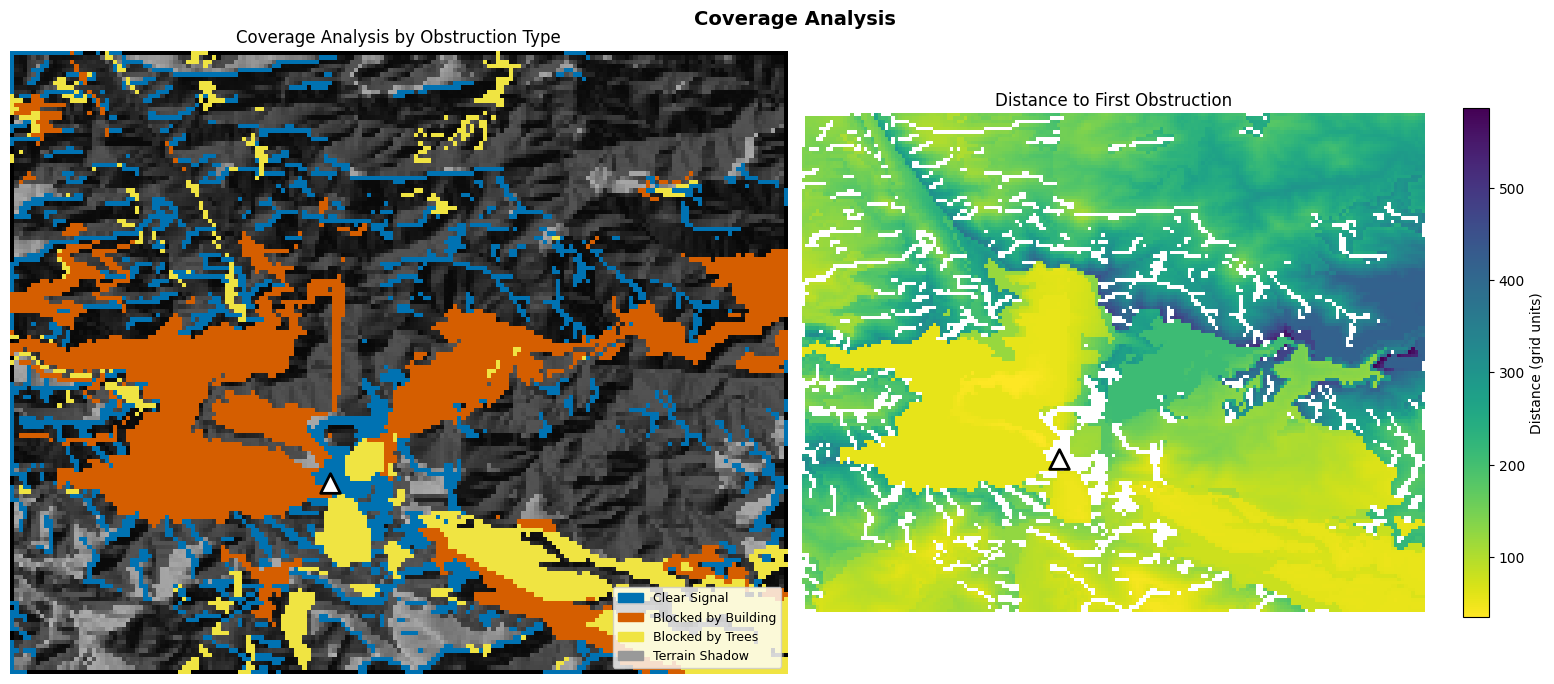

In [13]:
# Create a color-coded coverage visualization
# Using colorblind-friendly palette (Wong/IBM colors)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Color map for hit layers (colorblind-safe: blue/orange/yellow)
layer_colors = np.zeros((*hit_layers.shape, 3), dtype=np.uint8)

# Base: hillshade for context
hs_data = hs.data.get() if hasattr(hs.data, 'get') else hs.data
hs_norm = np.nan_to_num(hs_data, nan=0)
hs_gray = np.uint8(np.clip(hs_norm * 180, 0, 180))

layer_colors[:, :, 0] = hs_gray
layer_colors[:, :, 1] = hs_gray
layer_colors[:, :, 2] = hs_gray

# Overlay colors based on which layer blocks signal
# Clear line-of-sight: Blue (#0072B2)
clear_mask = (hit_layers == -1) | (hit_distances < 0)
layer_colors[clear_mask, 0] = 0
layer_colors[clear_mask, 1] = 114
layer_colors[clear_mask, 2] = 178

# Blocked by buildings: Orange (#D55E00)
building_mask = (hit_layers == LAYER_BUILDINGS)
layer_colors[building_mask, 0] = 213
layer_colors[building_mask, 1] = 94
layer_colors[building_mask, 2] = 0

# Blocked by trees: Yellow (#F0E442)
tree_mask = (hit_layers == LAYER_TREES)
layer_colors[tree_mask, 0] = 240
layer_colors[tree_mask, 1] = 228
layer_colors[tree_mask, 2] = 66

# Left plot: Layer hit visualization
axes[0].imshow(layer_colors)
axes[0].scatter(tower_col, tower_row, c='white', s=200, marker='^', 
                edgecolors='black', linewidths=2, zorder=10, label='Cell Tower')

# Add legend with colorblind-friendly colors
legend_patches = [
    mpatches.Patch(color='#0072B2', label='Clear Signal'),
    mpatches.Patch(color='#D55E00', label='Blocked by Building'),
    mpatches.Patch(color='#F0E442', label='Blocked by Trees'),
    mpatches.Patch(color='#999999', label='Terrain Shadow'),
]
axes[0].legend(handles=legend_patches, loc='lower right', fontsize=9)
axes[0].set_title('Coverage Analysis by Obstruction Type', fontsize=12)
axes[0].axis('off')

# Right plot: Hit distance (signal strength proxy)
hit_dist_masked = np.ma.masked_where(hit_distances < 0, hit_distances)
im = axes[1].imshow(hit_dist_masked, cmap='viridis_r')
axes[1].scatter(tower_col, tower_row, c='white', s=200, marker='^',
                edgecolors='black', linewidths=2, zorder=10)
axes[1].set_title('Distance to First Obstruction', fontsize=12)
axes[1].axis('off')
plt.colorbar(im, ax=axes[1], label='Distance (grid units)', shrink=0.8)

plt.suptitle("Coverage Analysis", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

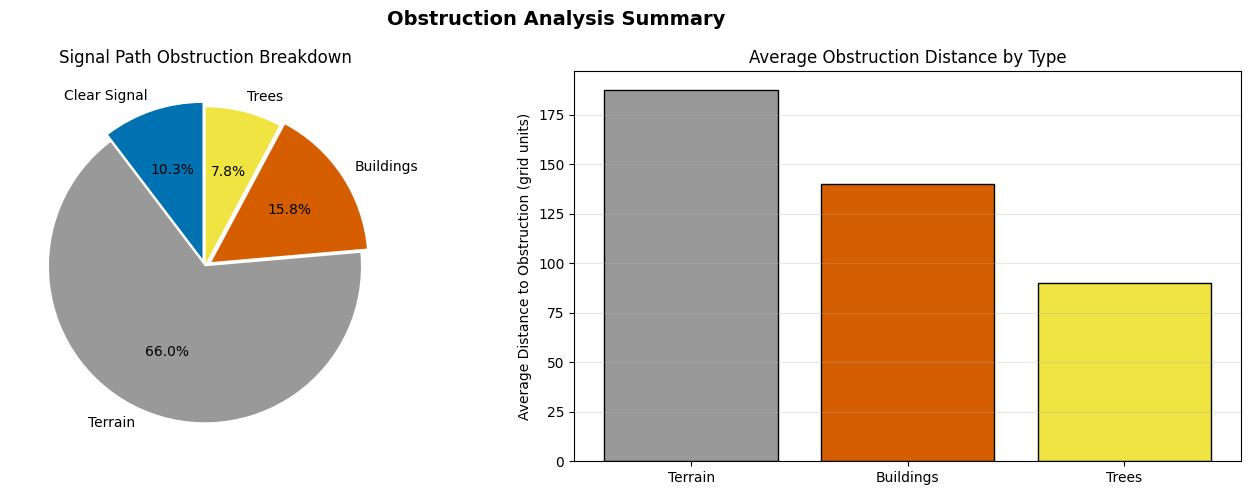

In [14]:
# Create pie chart and bar chart of obstruction types
# Using colorblind-friendly palette
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart with colorblind-safe colors
labels = ['Clear Signal', 'Terrain', 'Buildings', 'Trees']
sizes = [misses, terrain_hits, building_hits, tree_hits]
colors_pie = ['#0072B2', '#999999', '#D55E00', '#F0E442']
explode = (0.05, 0, 0.05, 0.02)

axes[0].pie(sizes, explode=explode, labels=labels, colors=colors_pie,
            autopct='%1.1f%%', startangle=90)
axes[0].set_title('Signal Path Obstruction Breakdown', fontsize=12)

# Bar chart of average hit distances by layer
avg_distances = []
for layer_id in [LAYER_TERRAIN, LAYER_BUILDINGS, LAYER_TREES]:
    mask = hit_layers == layer_id
    if mask.sum() > 0:
        valid_dists = hit_distances[mask]
        valid_dists = valid_dists[valid_dists > 0]
        avg_distances.append(np.mean(valid_dists) if len(valid_dists) > 0 else 0)
    else:
        avg_distances.append(0)

bar_labels = ['Terrain', 'Buildings', 'Trees']
bar_colors = ['#999999', '#D55E00', '#F0E442']
axes[1].bar(bar_labels, avg_distances, color=bar_colors, edgecolor='black')
axes[1].set_ylabel('Average Distance to Obstruction (grid units)')
axes[1].set_title('Average Obstruction Distance by Type', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

plt.suptitle('Obstruction Analysis Summary', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. 3D Scene Visualization

A 3D view showing the terrain, buildings, trees, and sample signal paths.

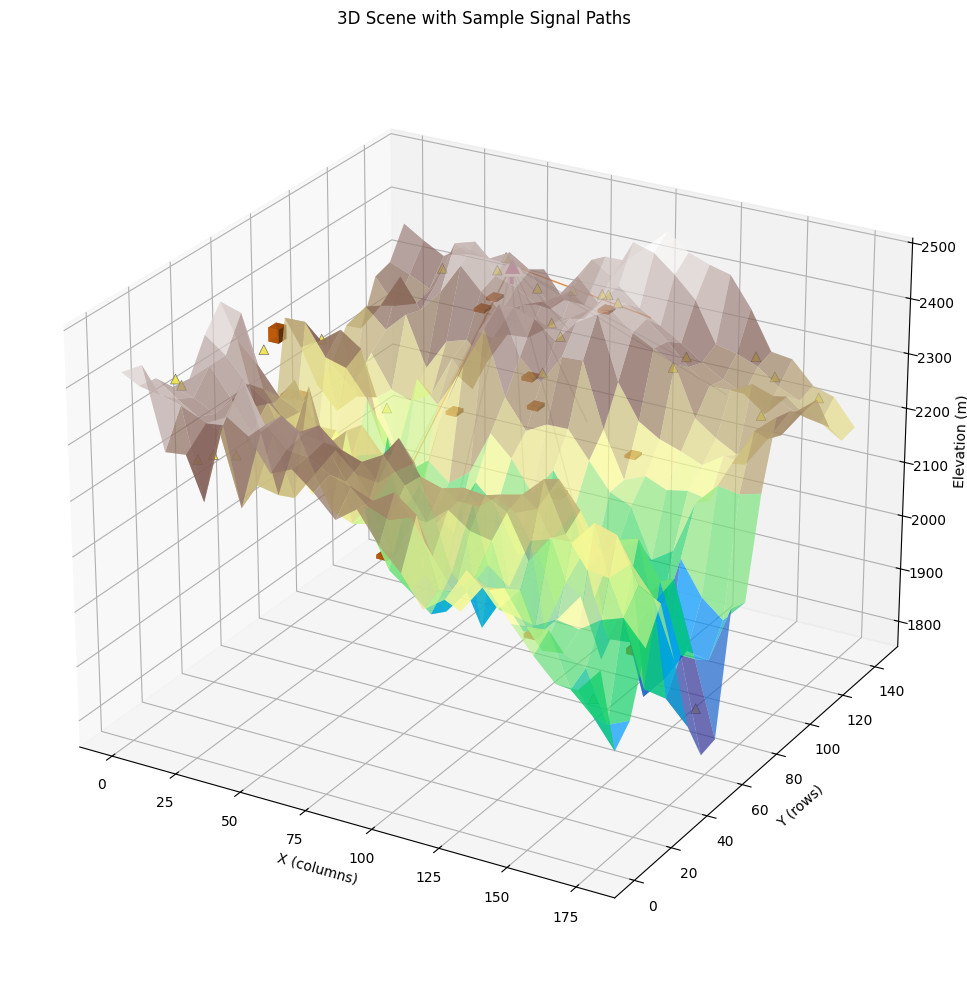

In [15]:
# Create a 3D visualization (subsampled for performance)
# Using colorblind-friendly palette
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Subsample terrain for 3D plot
subsample = 8
elev_sub = elev_data[::subsample, ::subsample]
H_sub, W_sub = elev_sub.shape

X = np.arange(0, W, subsample)
Y = np.arange(0, H, subsample)
X, Y = np.meshgrid(X, Y)

# Plot terrain surface
ax.plot_surface(X, Y, elev_sub, cmap='terrain', alpha=0.7, 
                linewidth=0, antialiased=True)

# Plot buildings as boxes (orange #D55E00)
for b in buildings[:15]:
    bx, by = b['col'], b['row']
    bz = b['z']
    h = b['height']
    ax.bar3d(bx-2, by-2, bz, 4, 4, h, color='#D55E00', alpha=0.8)

# Plot trees as points (yellow #F0E442)
tree_x = [t['col'] for t in trees[:30]]
tree_y = [t['row'] for t in trees[:30]]
tree_z = [t['z'] + t['trunk_height'] + t['canopy_height']/2 for t in trees[:30]]
ax.scatter(tree_x, tree_y, tree_z, c='#F0E442', s=50, marker='^', 
           alpha=0.9, edgecolors='#666666', linewidths=0.5)

# Plot tower (distinct purple #CC79A7)
ax.scatter([tower_col], [tower_row], [tower_z], c='#CC79A7', s=200, marker='^', 
           edgecolors='white', linewidths=2)
ax.plot([tower_col, tower_col], [tower_row, tower_row], 
        [tower_elev, tower_z], color='#CC79A7', linewidth=3)

# Draw sample rays from tower with colorblind-safe colors
np.random.seed(42)
for _ in range(10):
    target_row = np.random.randint(20, H-20)
    target_col = np.random.randint(20, W-20)
    target_z = float(elev_data[target_row, target_col]) + 1.5
    
    if hit_layers[target_row, target_col] == -1:
        color = '#0072B2'  # Blue for clear
        alpha = 0.6
    elif hit_layers[target_row, target_col] == LAYER_BUILDINGS:
        color = '#D55E00'  # Orange for buildings
        alpha = 0.7
    elif hit_layers[target_row, target_col] == LAYER_TREES:
        color = '#F0E442'  # Yellow for trees
        alpha = 0.8
    else:
        color = '#999999'  # Gray for terrain
        alpha = 0.4
    
    ax.plot([tower_col, target_col], [tower_row, target_row],
            [tower_z, target_z], color=color, alpha=alpha, linewidth=1)

ax.set_xlabel('X (columns)')
ax.set_ylabel('Y (rows)')
ax.set_zlabel('Elevation (m)')
ax.set_title('3D Scene with Sample Signal Paths', fontsize=12)

# Adjust view angle
ax.view_init(elev=25, azim=-60)

plt.tight_layout()
plt.show()

## 9. API Summary: Multi-GAS in rtxpy

Here's a quick reference for the multi-GAS features demonstrated in this notebook:

### Adding Geometry Layers

```python
rtx = RTX()
rtx.clear_scene()  # Start fresh

# Add geometry layers - each gets an Instance ID (0, 1, 2, ...)
rtx.add_geometry("terrain", terrain_verts, terrain_tris)      # Instance ID = 0
rtx.add_geometry("buildings", building_verts, building_tris)  # Instance ID = 1
rtx.add_geometry("trees", tree_verts, tree_tris)              # Instance ID = 2

# Optional: Add with transform (3x4 row-major matrix)
# [Xx, Xy, Xz, Tx, Yx, Yy, Yz, Ty, Zx, Zy, Zz, Tz]
rtx.add_geometry("translated", verts, tris, 
                 transform=[1,0,0,100, 0,1,0,0, 0,0,1,50])
```

### Tracing with Instance IDs

```python
# Prepare buffers
rays = np.float32([ox,oy,oz,tmin, dx,dy,dz,tmax, ...])  # 8 floats per ray
hits = np.zeros(num_rays * 4, dtype=np.float32)         # [t, nx, ny, nz] per ray
prim_ids = np.zeros(num_rays, dtype=np.int32)           # Triangle index
inst_ids = np.zeros(num_rays, dtype=np.int32)           # Geometry layer index

# Trace with instance ID output
rtx.trace(rays, hits, num_rays, 
          primitive_ids=prim_ids,  # Which triangle was hit
          instance_ids=inst_ids)   # Which geometry layer was hit

# inst_ids values:
# -1 = Ray missed all geometry
#  0 = Hit first geometry added ("terrain")
#  1 = Hit second geometry added ("buildings")
#  2 = Hit third geometry added ("trees")
#  etc.
```

### Other Multi-GAS Methods

```python
rtx.list_geometries()        # Returns: ["terrain", "buildings", "trees"]
rtx.get_geometry_count()     # Returns: 3
rtx.has_geometry("terrain")  # Returns: True
rtx.remove_geometry("trees") # Removes the trees layer
rtx.update_transform("buildings", new_transform)  # Update position/rotation
rtx.clear_scene()            # Remove all geometry
```

## 10. Summary

This notebook demonstrated multi-GAS ray tracing for RF coverage analysis. The key benefit is identifying not just *whether* a signal path is blocked, but *what* blocks it - enabling targeted solutions for each obstruction type.

### Key Takeaways

1. **Multi-GAS enables layer-aware ray tracing** - Know not just IF a ray hits, but WHAT it hits
2. **Instance IDs are assigned in order** - First `add_geometry()` = ID 0, second = ID 1, etc.
3. **Geometry can be dynamically managed** - Add, remove, update transforms at runtime
4. **Useful for scene analysis** - RF coverage, visibility studies, occlusion queries

### Ideas to Explore

- Move the tower location and re-run the analysis
- Add more buildings or trees and observe coverage changes
- Experiment with different tower heights
- Compare coverage from multiple potential tower sites
- Use `update_transform()` to test different building configurations